Implement greedy algorithm for submod. fn. Max. (IC):
 * For budget = 1 to n_documents
   * Simulate process k times for every new candidate, and pick candidate which, on average (i.e. in expectation), when added to the seed set maximizes the spread caused by the seed set

Request these votes, and aggregate in a fixed way (e.g. MV or MVNN).


In [1]:
%load_ext autoreload

In [44]:
import os
import sys

print("Current Python: {0}".format(sys.executable))

# This makes Jupyter pretend to be Pythonic and play well with modules.
sys.path.append(os.path.expandvars(os.path.join(os.getcwd(), '..')))

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

from collections import OrderedDict
from datetime import datetime
import io
import os
import random

%matplotlib inline

Current Python: /Users/andrei/anaconda3/envs/crowd/bin/python


In [20]:
%autoreload 2

from crowd.aggregation import *
from crowd.config import *
from crowd.data import *
from crowd.file_util import *
from crowd.graph import *
from crowd.simulation import *
from crowd.topic import *
from crowd.util import *

In [4]:
SIM_THRESHOLD = 0.75
DISCARD_EMPTY_NODES = True

id_topic_info = load_topic_metadata()
judgements = read_useful_judgement_labels(JUDGEMENT_FILE)
test_data = read_all_test_labels()

# Pick one single topic to mess around with at the moment.
# Topic: 20814 Elvish Language
topic_id = '20814'
# topic_id = '20704'
graph = build_nx_document_graph(
    id_topic_info[topic_id],
    test_data,
    get_topic_judgements_by_doc_id(topic_id, judgements),
    FULLTEXT_FOLDER,
    sim_threshold=SIM_THRESHOLD,
    discard_empty=DISCARD_EMPTY_NODES)
classic_graph = build_document_graph(
    id_topic_info[topic_id],
    FULLTEXT_FOLDER,
    sim_threshold=SIM_THRESHOLD)
topic_judgements = get_topic_judgements_by_doc_id(topic_id, judgements)
topic_ground_truth = {truth.document_id: truth for truth in test_data
                          if truth.topic_id == topic_id}
print(len(topic_judgements.keys()))
print(len(topic_ground_truth.keys()))

# Important note: Not discarding empty nodes significantly slows the algorithm
# down, since the information propagation must then be computed on a much larger
# graph.
if DISCARD_EMPTY_NODES:
    print("Will DISCARD empty nodes in the graph.")
else:        
    # TODO(andrei): Ensure that when we're sampling, we DON'T try to sample
    # any of the votes which have not recorded votes.
    print("Not discarding empty nodes")
    
print("Nodes: {}".format(graph.nx_graph.number_of_nodes()))
print("Edges: {}".format(graph.nx_graph.number_of_edges()))

Building nx doc graph
7 relevant documents
3 non-relevant documents
100 documents with votes
66 hidden nodes (due to no data)
100
100
Will DISCARD empty nodes in the graph.
Nodes: 100
Edges: 62


In [5]:
# This is just a sanity check preview. It's not nearly
# as useful as the one in the dedicated similarity graph
# visualization notebook.
# TODO(andrei): Consider always working with NetworkX graphs directly, if it makes sense.

plt.rcParams['figure.figsize'] = (18, 10)

# from networkx.drawing.nx_agraph import graphviz_layout
# pos = graphviz_layout(graph.nx_graph)
# nx.draw(graph.nx_graph, pos, node_size=2500, node_color='w')
# _ = nx.draw_networkx_labels(graph.nx_graph, pos)
# # _ = nx.draw_networkx_edge_labels(graph.nx_graph, pos)
# nx.draw_networkx_edges(graph.nx_graph, pos)

print("Connected components: {}".format(nx.number_connected_components(graph.nx_graph)))
print("Cliques:              {}".format(nx.graph_number_of_cliques(graph.nx_graph)))

# nx.draw(graph.nx_graph)

Connected components: 68
Cliques:              70


In [6]:
ng = graph.nx_graph
n_docs = ng.number_of_nodes()

In [7]:
# Getting a particular node's neighbors.
# Note that the actual node objects are of type 'NxDocumentNode' and 
ng['clueweb09-en0007-20-27316']

{clueweb09-en0020-09-05220: {'similarity': 0.83260761009306117},
 clueweb09-en0022-00-14843: {'similarity': 0.82834612080853465},
 clueweb09-en0027-48-27832: {'similarity': 0.95115279699710087},
 clueweb09-en0035-25-25842: {'similarity': 0.83333782655166722},
 clueweb09-en0065-64-28203: {'similarity': 0.78686207716967493},
 clueweb09-en0112-39-04197: {'similarity': 0.9701917457905459}}

## TODO list
 * Simulate one iteration of influence maximization under IC.
 * Create function which repeats simulation k several times, and computes the expected influence of a given seed set.
 * Create function which, given a seed set, finds the best addition to that seed set using the above function.
 * Create function which, given a graph and a budget b, computes the approximately best solution to maximize influence.
     * These will be the votes we will request.
 * Plot learning curves for this system, e.g. from budget = 1, up to budget = n_docs, or even n_docs * nr_votes_per doc.
 * Problem: What to do once we reach 100% coverage, i.e. 1 vote for every document?
     * We encounter a similar problem to GP aggregation, cyclicity. Namely, influence spread is maximized when we have sampled every node exactly once, but this doesn't mean that we should be 100% confident our predictions are correct.
     * We need a smart way to model uncertainty beyond 1 vote per doc.
     * Possible solution: Remodel influence maximization problem so that every node spreads information based on its own confidence. If there is consent among voters so far, then its weight is higher than if there is dissent.
 * This technique is VERY CPU-intensive, but also embarrassingly parallel, so we should parallelize it.
 * Write script for one-command deployment to Euler (hint: use pyinvoke).
 * Model IC/LT configs in a neat OO fashion.
 * Consider estimating the number of tries necessary if using a brute-force approach. For instance, for $n = 150$ documents and a budget $k = b = 15$ we would have to check about $10^{20}$ possible subsets. And this doesn't even count possible uncertainties and needing >1 vote per document to be confident in its relevance. We need submodularity! The **k-max cover problem** is NP-hard.

In [8]:
# TODO(andrei): Be very rigorous with RNG.
import random

def sample_edges(graph, seed_set):
    # Samples every edge in the graph with the probability = similarity.
    # Return the set of reachable nodes given the seed set and the edges we sampled.
    
    sampled = nx.Graph(graph)
    sampled.remove_edges_from(sampled.edges())

    for from_node, to_node, data in graph.edges(data=True):
        if random.random() <= data['similarity']:
            # TODO(andrei): Batching this (i.e. only add all sampled at once) might
            # speed things up!
            sampled.add_edge(from_node, to_node)
    
    # Compute the reachability given the seed set and the nodes we sampled.
    all_reached = set()
    for seed_node in seed_set:
        reached = set(nx.shortest_path(sampled, source=seed_node).keys())
        all_reached |= reached
        
    return all_reached


def simulate_spread(graph, seed_set, iteration_count):
    """Simulates information spread in 'graph' using IC model.
    
    Returns:
        The influence spread of the given seed set in the graph.
        This is a number beween 0 and the size of the graph signifying
        the number of nodes we expect to reach from the seed set in the
        given graph, approximated using 'iteration_count' iterations.
    """
    reach_sum = 0
    
    for k in range(iteration_count):
        result = sample_edges(graph, seed_set)
        reach_sum += len(result)
        
    reach_exp = reach_sum / iteration_count
    return reach_exp


# TODO(andrei): Use this to test lazy greedy implementation. Should be quite easy.
def pick_next_best(graph, current_seed_set, iteration_count):
    """Picks the node which best improves the information spread of the seed set.
    
    This is a greedy approach, which works because the influence spread function
    is submodular.
    """
    
    best_spread = -1
    best_node = None
    for node in graph.nodes():
        if node not in current_seed_set:
            expected_spread = simulate_spread(
                graph,
                # TODO(andrei): Is there a better way to do this?
                current_seed_set | { node },
                iteration_count)
            
            if expected_spread > best_spread:
                best_spread = expected_spread
                best_node = node
                
    assert best_node is not None, "Must select a node to add to the seed set."
    return best_node, best_spread


def build_seed_set(graph, budget, iteration_count):
    seed_set = set()
    for index in range(budget):
        # TODO(andrei): Consider detecting when spread stops improving and quitting early. Does it ever happen?
        best_node, best_spread = pick_next_best(graph, seed_set, iteration_count)
        print("Budget: {}/{}, Spread: {:.2f}".format(index + 1, budget, best_spread))
        seed_set.add(best_node)
        
    return seed_set

## Lazy Greedy

In [9]:
import heapq

def compute_best_heap(graph, current_seed_set, prev_spread, iteration_count):
    """Similar to 'pick_next_best', but returns a priority queue of all candidates."""
    
    spread_node_heap = []
    for node in graph.nodes():
        # Skip nodes which are not safe to sample because they have no real votes.
#         if node.document_id not in safe_sample_set:
#             continue
            
        if node not in current_seed_set:
            expected_benefit = simulate_spread(
                graph,
                current_seed_set | {node},
                iteration_count)
            assert prev_spread <= 0
            node_marginal_benefit = expected_benefit - (-prev_spread)
            # By default, python's heap is a min-heap, so we need to invert this here sign.
            # TODO(andrei): Is the negative hack needed? Consider implementing a min/max-heap wrapper.
            # Implementing a dedicated max-heap will also make your code much clearer.
            heapq.heappush(spread_node_heap, (-node_marginal_benefit, -expected_benefit, node))
            
    assert len(spread_node_heap) > 0, "Must find at least one candidate node."
    return spread_node_heap


def pick_next_best_lazy(graph, current_seed_set, iteration_count, previous_best_heap, prev_spread, stats):
    # TODO(andrei): Better docs once interface stable.
    # TODO(andrei): Re-add safe sample set.
    # safe_sample_set: The IDs we are actually allowed to try out, since we can't pick 
    # any node because many don't have any votes to sample from in our simulation!!!
    
    if len(previous_best_heap) < 2:
        # Heap not enough for any sensible lazy greediness.
        return compute_best_heap(graph, current_seed_set, 0, iteration_count)
    
    # The first value in the previous best heap has already been added to the seed set.
    best, second_best = heapq.nsmallest(2, previous_best_heap)
    #prev_delta, prev_spread, prev_added_node = prev
    best_delta, best_spread, best_node = best
    second_best_delta, second_best_spread, second_best_node = second_best
    
    #print("Second best delta: {}".format(second_best_delta))
    
    #print("Best node in heap now: {}".format(best_node))
    #print("Second node in heap now: {}".format(second_best_node))
    #print("Top node snapshot: {}".format([str(e[2]) + " " + str(e[1]) for e in heapq.nsmallest(10, previous_best_heap)]))
    
    #assert prev_added_node in current_seed_set
    
    recomputed_best_score = simulate_spread(graph, current_seed_set | {best_node}, iteration_count)
    # Note: prev_spread is negative!
    # TODO(andrei): The algorithm in its early stages is slowed down by cliques in the graph => bad lazy greedy performance. Write about this in the report.
    # The same happens in the later stages: there we are only sampling unconnected nodes (1-cliques).
    recomputed_best_delta = -(recomputed_best_score + prev_spread)
    #print("Recomputed best delta: {} vs second_best: {}".format(-recomputed_best_delta, -second_best_delta))
    #print("This delta used to be: {}".format(-best_delta))
    
    EPSILON = 0.5
    if recomputed_best_delta <= second_best_delta + EPSILON:
        stats['hit'] += 1
        # We succeeded in being lazy! Update the delta and score for the element.
        # Note: heapreplace returns the smallest! 
        _ = heapq.heapreplace(previous_best_heap, (recomputed_best_delta, -recomputed_best_score, best_node))
        return previous_best_heap
    else:
        stats['miss'] += 1
        # Need to do a full recompute. Oh well.
        return compute_best_heap(graph, current_seed_set, prev_spread, iteration_count)


def build_seed_set_lg(graph, budget, iteration_count):
    best_heap = []
    seed_set = set()
    best_spread_delta = 0
    best_spread = 0
    best_node = None
    stats = {'hit': 0, 'miss': 0}
    for index in range(budget):
        prev_spread = best_spread
        best_heap = pick_next_best_lazy(graph, seed_set, iteration_count, best_heap, prev_spread, stats)
        best_spread_delta, best_spread, best_node = heapq.heappop(best_heap)
        print("Budget: {}/{}, Spread: {:.2f}".format(index + 1, budget, best_spread))
        seed_set.add(best_node)
        
    print("Stats: ", stats)
    return seed_set

# General benchmarks; topic = 20814
#
#  * Very first timing,               b = 10, it = 10:    77639828 function calls in 26.211 seconds
#  * Pre-cached node hash,            b = 10, it = 10:    49998191 function calls in 20.735, 21.717, 21.289 seconds
#  * First buggy lazy greedy attempt, b = 10, it = 10:    25624964 function calls in 10.595 seconds
#  * Second less buggy lg attempt,    b = 30, it = 10:    139919933 function calls in 57.896 seconds 
#    spread = 61.60
# Fishy...
#  * Non-lg                           b = 30, it = 10:    138283442 function calls in 57.391 seconds
#    spread = 61.20


# Clique-based investigation:
#  lt  lazy greedy comparison:  {'miss': 12, 'hit': 5}, spread == 49.5
#  lte lazy greedy comparison:  {'miss': 12, 'hit': 5} spread == 49.5
#  epsilon 0.1 lazy greedy comparison: {'miss': 13, 'hit': 4}  Spread == 49.50
#  epsilon 0.5 lazy greedy comparison: {'miss': 8, 'hit': 9}   Spread == 49.20
#  epsilon 1.0 lazy greedy comparison: {'miss': 8, 'hit': 9}   Spread == 49.20
#  epsilon 2.5 lazy greedy comparison: {'miss': 5, 'hit': 12}  Spread == 49.20

random.seed(0xFFF000)
%prun result = build_seed_set_lg(graph.nx_graph, 15, 10)
clean_res = []
for r in result:
    d_id = r.document_id
    d_id = d_id[d_id.find('-') + 1:]
    d_id = d_id[d_id.find('-') + 1:]
    clean_res.append(d_id)
    
print(sorted(clean_res))

Budget: 1/15, Spread: -8.00
Budget: 2/15, Spread: -14.00
Budget: 3/15, Spread: -18.00
Budget: 4/15, Spread: -22.00
Budget: 5/15, Spread: -25.00
Budget: 6/15, Spread: -27.00
Budget: 7/15, Spread: -27.00
Budget: 8/15, Spread: -30.90
Budget: 9/15, Spread: -32.90
Budget: 10/15, Spread: -35.00
Budget: 11/15, Spread: -34.90
Budget: 12/15, Spread: -34.80
Budget: 13/15, Spread: -38.00
Budget: 14/15, Spread: -40.70
Budget: 15/15, Spread: -42.90
Stats:  {'miss': 8, 'hit': 6}
 ['03-20830', '03-20850', '08-09915', '14-28985', '18-32052', '20-27316', '22-17024', '23-17067', '34-30758', '57-36727', '62-23911', '73-34819', '74-02002', '80-16439', '89-33025']


In [10]:
if False:
    result = build_seed_set(graph.nx_graph, 10, 10)
    clean_res = []
    for r in result:
        d_id = r.document_id
        d_id = d_id[d_id.find('-') + 1:]
        d_id = d_id[d_id.find('-') + 1:]
        clean_res.append(d_id)

    print(sorted(clean_res))

## Sampling + vote aggregation

In [22]:
class GraphSpreadSampler(DocumentSampler):
    """Tries to sample nodes which maximize information spread.
    
    Uses a greedy approach as the objective function we are trying
    to maximize under the information diffusion model is submodular.
    
    Note: When parallelizing computations, make sure that each worker
    gets its own sampler, as they are stateful. Failure to do so leads
    to race conditions.
    """
    
    def __init__(self, topic_graph, **kw):
        self.topic_graph = topic_graph
        self.seed_set = set()
        self.iteration_count = kw.get('iteration_count', 5)

    def sample(self, existing_votes):
        raise RuntimeError("DO NOT USE THIS. IT IS BUGGY.")
        best_node, best_spread = pick_next_best(
            self.topic_graph.nx_graph,
            self.seed_set,
            self.iteration_count)
        self.seed_set.add(best_node)
        return best_node.document_id
        

class LazyGreedyGraphSpreadSampler(DocumentSampler):
    """Same as 'GraphSpreadSampler' but in a lazy greedy fashion.
    """
    
    def __init__(self, topic_graph, **kw):
        self.topic_graph = topic_graph
        self.seed_set = set()
        self.iteration_count = kw.get('iteration_count', 5)
        self.best_heap = []
        self.best_spread_delta = 0
        self.best_spread = 0
        self.stats = {'hit': 0, 'miss': 0}
        
    def sample(self, existing_votes, available_topic_judgement):
        prev_spread = self.best_spread
        self.best_heap = pick_next_best_lazy(
            self.topic_graph.nx_graph,
            self.seed_set,
            self.iteration_count, 
            self.best_heap,
            prev_spread,
            # Limit the nodes we're allowed to sample to the ones for which
            # we have votes, without getting rid of nodes with no info altogether,
            # as they may be the way towards other interesting nodes in our information
            # diffusion model.
            # TODO(andrei): Re-enable this once you speed the code up.
            #available_topic_judgement.keys(),
            self.stats)

        _, self.best_spread, self.best_node = heapq.heappop(self.best_heap)
        #print("Budget: {}/{}, Spread: {:.2f}".format(index + 1, budget, best_spread))
        self.seed_set.add(self.best_node)
        return self.best_node.document_id

# Least votes sampling
print("Oldschool least-votes")
accuracies_mv_lowvotes = evaluate_iteration(
    classic_graph,
    topic_judgements,
    topic_ground_truth,
    LeastVotesSampler(),
    aggregate_MV,
    budget=len(topic_ground_truth.keys()))
accuracies_mev_lowvotes = evaluate_iteration(
    classic_graph,
    topic_judgements,
    topic_ground_truth,
    LeastVotesSampler(),
    aggregate_mev,
    budget=len(topic_ground_truth.keys()))
    
# IC sampling
print("IC")
accuracies_mev = evaluate_iteration(
    graph,
    topic_judgements,
    topic_ground_truth,
#     GraphSpreadSampler(graph, iteration_count=5),
    LazyGreedyGraphSpreadSampler(graph, iteration_count=5),
    aggregate_mev_nx,
    budget=len(topic_ground_truth.keys()))
accuracies_mv = evaluate_iteration(
    graph,
    topic_judgements,
    topic_ground_truth,
#     GraphSpreadSampler(graph, iteration_count=5),
    LazyGreedyGraphSpreadSampler(graph, iteration_count=5),
    aggregate_MV,
    budget=len(topic_ground_truth.keys()))
print("Done.")

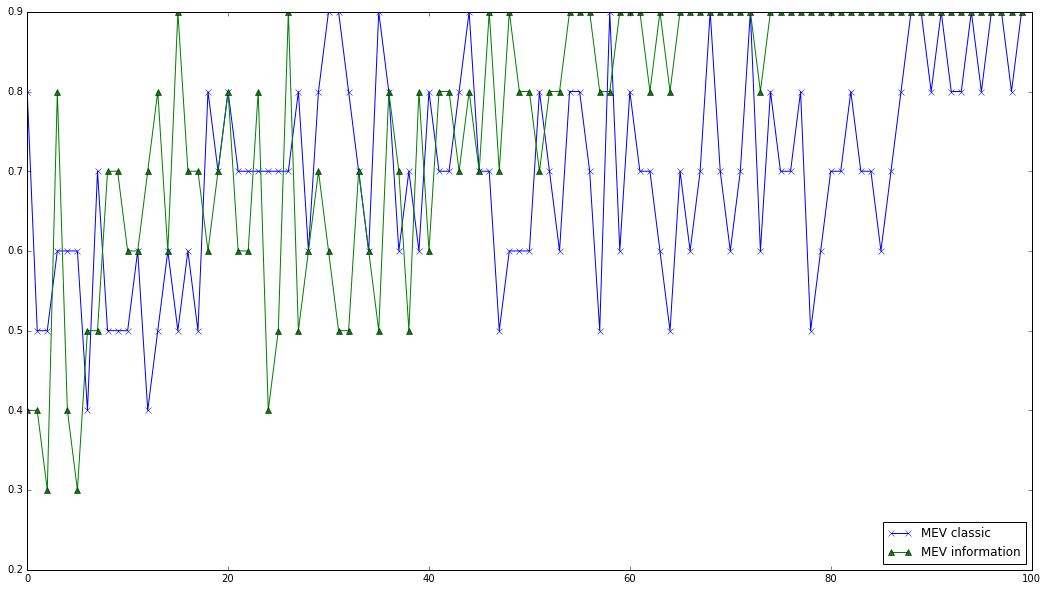

In [23]:
plt.plot(range(len(accuracies_mev_lowvotes)), accuracies_mev_lowvotes, label="MEV classic", marker='x')
#plt.plot(range(len(accuracies_mv_lowvotes)), accuracies_mv_lowvotes, label="MV", marker='x')

plt.plot(range(len(accuracies_mev)), accuracies_mev, label="MEV information", marker='^')
#plt.plot(range(len(accuracies_mv)), accuracies_mv, label="MV", marker='^')
plt.legend(loc='lower right')

In [13]:
# TODO(andrei): Improve modularization, and use more specific name for 'evaluate' 'iterations' arg.

def lgss_factory(graph, iteration_count):
    """Ensures that each worker in 'evaluate' has its own copy of the sampler (which is stateful!)."""
    def res():
        return LazyGreedyGraphSpreadSampler(graph, iteration_count=iteration_count)
    
    return res

In [24]:
ic_graph, _ = evaluate(
    graph,
    topic_judgements,
    topic_ground_truth,
    lgss_factory(graph, 1),
    aggregate_mev_nx,
    budget=len(topic_ground_truth.keys()),
    iterations=25)

In [25]:
least_votes, _ = evaluate(
    graph,
    topic_judgements,
    topic_ground_truth,
    LeastVotesSampler(),
    aggregate_mev_nx,
    budget=len(topic_ground_truth.keys()),
    iterations=25)

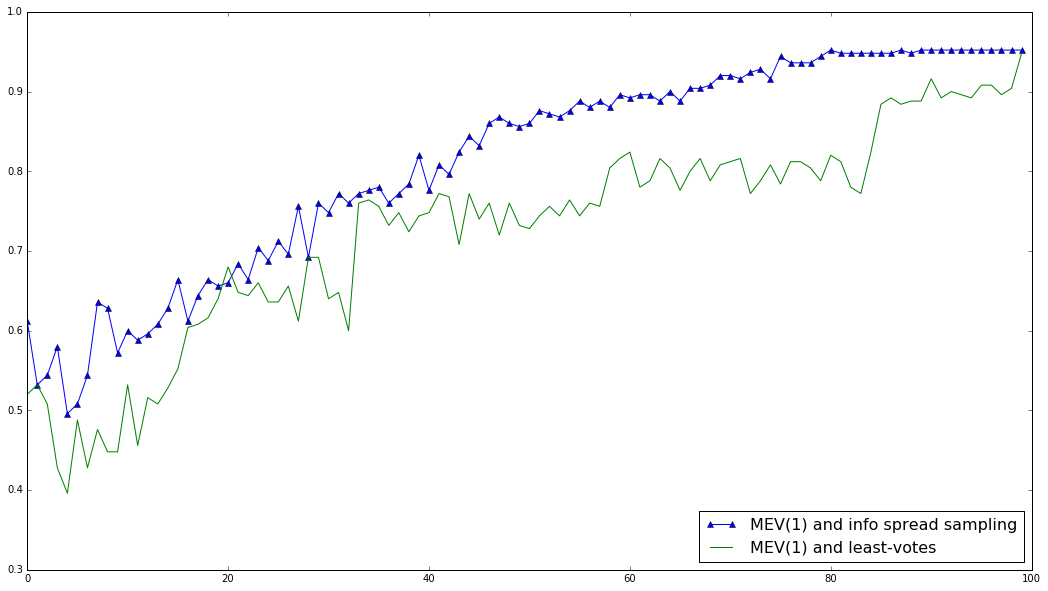

In [37]:
ic_graph_avg = np.mean(ic_graph, axis=0)
least_votes_avg = np.mean(least_votes, axis=0)        
plt.plot(range(len(ic_graph_avg)), ic_graph_avg, label="MEV(1) and info spread sampling", marker='^')
plt.plot(range(len(least_votes_avg)), least_votes_avg, label="MEV(1) and least-votes")
plt.legend(loc=4, fontsize=16)

In [53]:
def compare_sampling(tid, sim_threshold=SIM_THRESHOLD):
    id_topic_info = load_topic_metadata()
    judgements = read_useful_judgement_labels(JUDGEMENT_FILE)
    test_data = read_all_test_labels()

    print("Comparing least-votes and graph-based sampling for topic: {} (ID#{})".format(
        id_topic_info[tid].query,
        tid))
    nx_graph = build_nx_document_graph(
        id_topic_info[tid],
        test_data,
        get_topic_judgements_by_doc_id(tid, judgements),
        FULLTEXT_FOLDER,
        sim_threshold=sim_threshold,
        discard_empty=DISCARD_EMPTY_NODES)
    topic_judgements = get_topic_judgements_by_doc_id(tid, judgements)
    topic_ground_truth = {truth.document_id: truth for truth in test_data
                          if truth.topic_id == tid}
    
    print("Judgements: {}".format(len(topic_judgements.keys())));
    print("Ground truths: {}".format(len(topic_ground_truth.keys())))
    
    graph_simulation_iterations = 5
    aggregation_iterations = 25
    print("Computing results for IC Information Spread Sampler...")
    
    ic_graph_result, ic_time_s = evaluate(
        nx_graph,
        topic_judgements,
        topic_ground_truth,
        lgss_factory(nx_graph, graph_simulation_iterations),
        aggregate_mev_nx,
        budget=len(topic_judgements.keys()),
        iterations=aggregation_iterations)
    ic_sampling_info = "{0} info propagation simulation iterations; {1}; {2:.4f} s".format(
        graph_simulation_iterations,
        ("Discarded" if DISCARD_EMPTY_NODES else "Not discarded") + " graph empty nodes",
        ic_time_s
    )
    
    print("Computing results for LeastVotesSampler...")
    
    least_votes_result, lv_time_s = evaluate(
        nx_graph,
        topic_judgements,
        topic_ground_truth,
        LeastVotesSampler(),
        aggregate_mev_nx,
        budget=len(topic_judgements.keys()),
        iterations=aggregation_iterations)
    
    print("Plotting...")
    plt.rcParams['figure.figsize'] = (18, 10)
    
    # TODO(andrei): More info on plot.
    ic_graph_avg = np.mean(ic_graph_result, axis=0)
    least_votes_avg = np.mean(least_votes_result, axis=0)        
    plt.plot(range(len(ic_graph_avg)), ic_graph_avg, label="MEV(1) and info spread sampling", marker='^')
    plt.plot(range(len(least_votes_avg)), least_votes_avg, label="MEV(1) and least-votes")
    title = "Sampling technique comparison; IC sampling: {}; Date: {}; Git: {}; Graph similarity threshold: {}; Iterations: {}".format(
        ic_sampling_info,
        now.strftime("%Y-%m-%d %H:%M"),
        get_git_revision_hash(),
        SIM_THRESHOLD,
        iterations)
    plt.title(title)
    plt.grid()
    plt.legend(loc='lower right', fontsize=16)
    
#     now = datetime.now()
#     plotname = "sampling-comparison-{}-{}-{}-{}-{}".format(
#         tid,
#         now.strftime("%Y%m%dT%H%M"),
#         get_git_revision_hash(),
#         sim_threshold,
#         aggregation_iterations)
#     plt.savefig('../plots/{}.svg'.format(plotname))

Comparing least-votes and graph-based sampling for topic: detroit riot (ID#20704)
Building nx doc graph
5 relevant documents
5 non-relevant documents
90 documents with votes
51 hidden nodes (due to no data)
Judgements: 90
Ground truths: 90
Computing results for IC Information Spread Sampler...
Computing results for LeastVotesSampler...
Plotting...


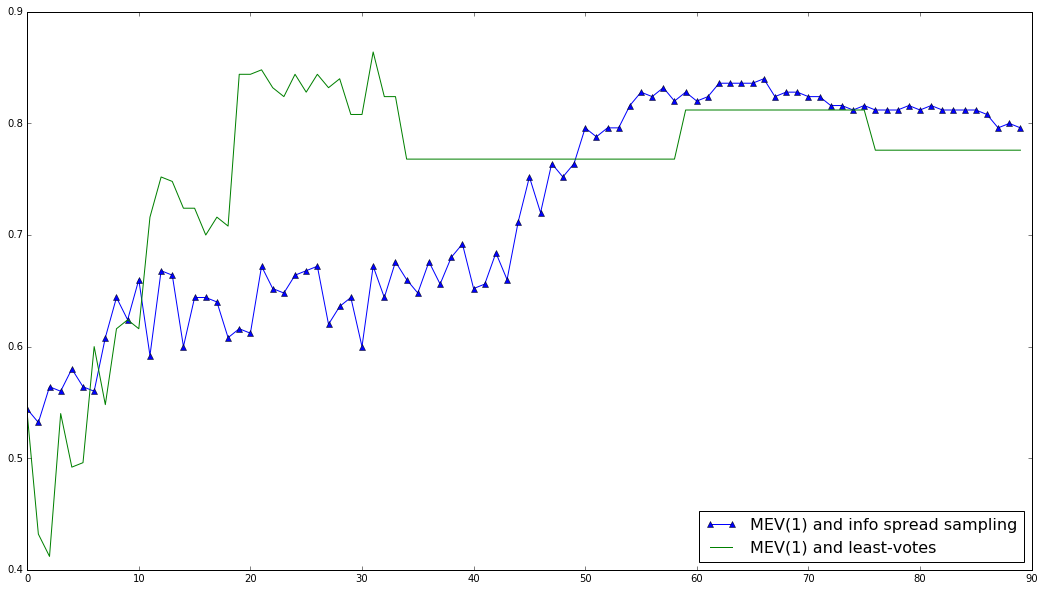

In [19]:
compare_sampling('20704')

Comparing least-votes and graph-based sampling for topic: elvish language (ID#20814)
Building nx doc graph
7 relevant documents
3 non-relevant documents
100 documents with votes
66 hidden nodes (due to no data)
Judgements: 100
Ground truths: 100
Computing results for IC Information Spread Sampler...
Computing results for LeastVotesSampler...
Plotting...


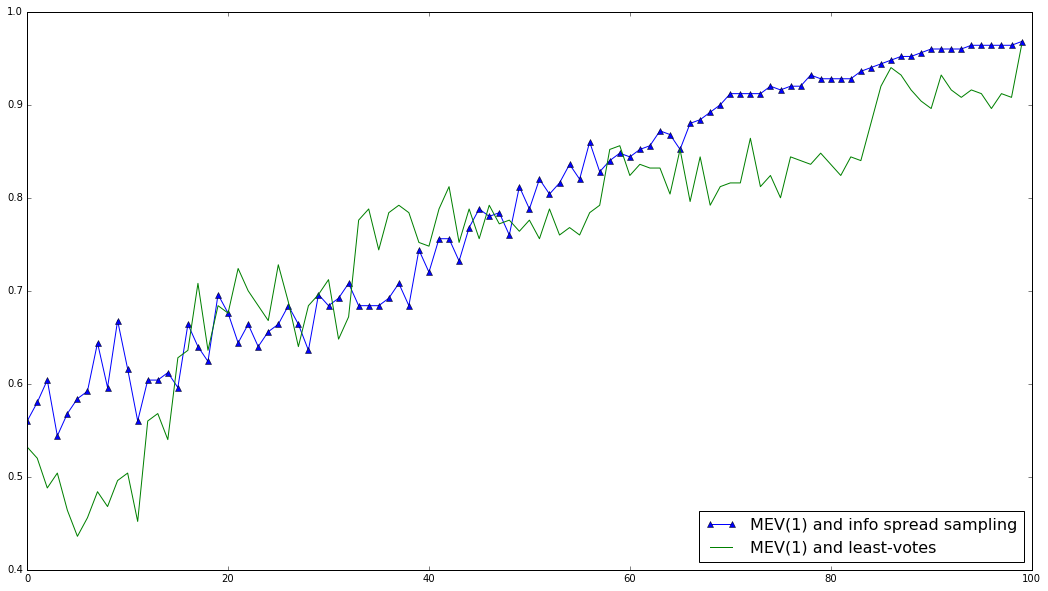

In [17]:
compare_sampling('20814')

Comparing least-votes and graph-based sampling for topic: translate german to english (ID#20932)
Building nx doc graph
12 relevant documents
3 non-relevant documents
115 documents with votes
130 hidden nodes (due to no data)
Judgements: 115
Ground truths: 115
Computing results for IC Information Spread Sampler...
Computing results for LeastVotesSampler...
Plotting...


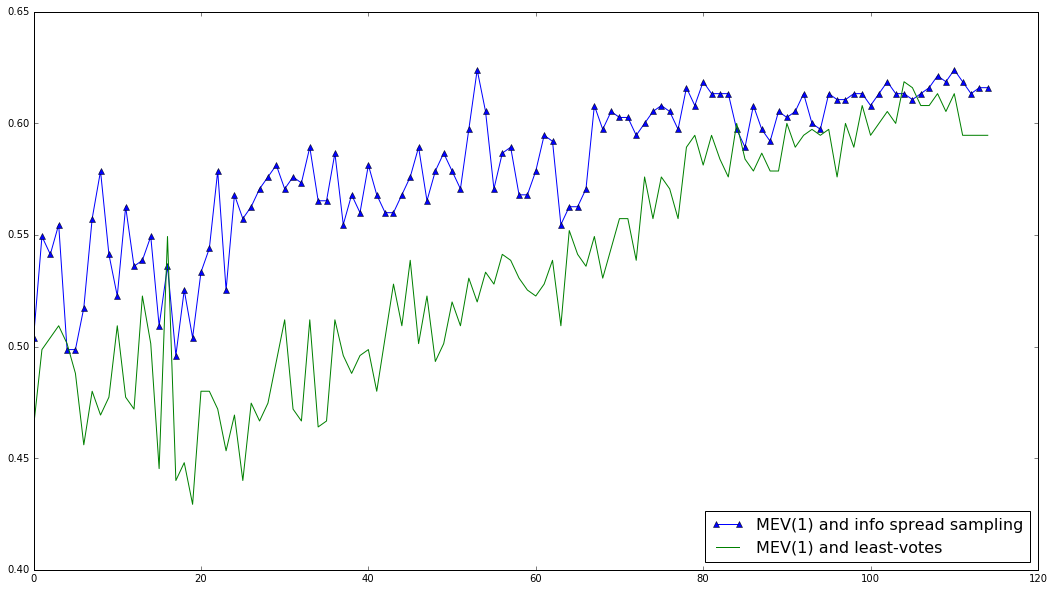

In [18]:
compare_sampling('20932')

In [ ]:
print("THIS IS AN INVALID PLOT PLEASE IGNORE")
compare_sampling('20832')

THIS IS AN INVALID PLOT PLEASE IGNORE
Comparing least-votes and graph-based sampling for topic: orlando sentinel (ID#20832)
Building nx doc graph
8 relevant documents
2 non-relevant documents
100 documents with votes
36 hidden nodes (due to no data)
Judgements: 100
Ground truths: 100
Computing results for IC Information Spread Sampler...


## Thoughts on also achieving voting confidence

 * Need **measure** of confidence in node.
 * Need to adapt sampling. With IC model, as soon as we reach a node with one edge, we "activate" it.
 * Linear Threshold (LT) model could be better? Then, a node would only "activate" if k neighbors (depending on similarity and its internal threshold) give it a heads-up. Still doesn't model confidence in votes in a particular node.
 * What if we re-weight the edges based the number of nodes? Still can't make the model want to pick a node more than once.
 * What about always picking e.g. 4 votes? If there's consent, we don't look at the node ever again until it's picked "naturally" again. If not, we want more votes there. Maybe just pick e.g. 4 votes again. If still no consent give up?
 
Want to do global sampling based on confidence and informativeness. I.e. we want to weight informativeness by lack of confidence, in order to prioritize nodes where we have little confidence in their relevance.

What does it mean to not have confidence in a document's relevance?
 * It has very few votes or none at all.
 * There's dissent among voters.
 * Want to design a `function(node, pos_votes, neg_votes)` which represents a measure of our confidence in its relevance.
 * We then want to use this somehow in conjunction with another sampling technique to pick the best node at a given time.
     * How?


## Result Log

First algorithm testing. SIM_THRESHOLD = 0.75, topic = '20814'

* B = 10, it = 1

```
Budget: 1/10, Spread: 8.00
Budget: 2/10, Spread: 14.00
Budget: 3/10, Spread: 18.00
Budget: 4/10, Spread: 22.00
Budget: 5/10, Spread: 25.00
Budget: 6/10, Spread: 27.00
Budget: 7/10, Spread: 29.00
Budget: 8/10, Spread: 31.00
Budget: 9/10, Spread: 33.00
Budget: 10/10, Spread: 35.00
['11-30471', '15-00571', '22-17024', '23-17065', '34-30758', '61-26427', '62-23911', '67-08444', '87-16214', '89-19116']
```

* B = 10, it = 5
 
```
Budget: 1/10, Spread: 8.00
Budget: 2/10, Spread: 14.00
Budget: 3/10, Spread: 18.00
Budget: 4/10, Spread: 22.00
Budget: 5/10, Spread: 25.00
Budget: 6/10, Spread: 27.00
Budget: 7/10, Spread: 29.00
Budget: 8/10, Spread: 31.00
Budget: 9/10, Spread: 33.00
Budget: 10/10, Spread: 35.00
['03-20962', '15-00571', '18-32052', '22-17024', '23-17065', '57-36745', '61-26427', '67-08444', '87-16214', '89-19116']
```
 
 * B = 10, it = 10:
 
```
Budget: 1/10, Spread: 8.00
Budget: 2/10, Spread: 14.00
Budget: 3/10, Spread: 18.00
Budget: 4/10, Spread: 22.00
Budget: 5/10, Spread: 24.80
Budget: 6/10, Spread: 27.00
Budget: 7/10, Spread: 29.00
Budget: 8/10, Spread: 31.00
Budget: 9/10, Spread: 32.90
Budget: 10/10, Spread: 35.00
['08-09915', '09-38244', '22-17024', '23-17067', '34-30758', '61-26427', '67-08444', '78-09824', '87-16214', '91-14026']

```

 * B = 10, it = 50
 
```
Budget: 1/10, Spread: 8.00
Budget: 2/10, Spread: 13.98
Budget: 3/10, Spread: 18.00
Budget: 4/10, Spread: 21.98
Budget: 5/10, Spread: 24.92
Budget: 6/10, Spread: 26.90
Budget: 7/10, Spread: 28.84
Budget: 8/10, Spread: 30.94
Budget: 9/10, Spread: 32.90
Budget: 10/10, Spread: 34.80
['11-30471', '25-25842', '34-30758', '61-21414', '63-26631', '74-02002', '78-09824', '80-16439', '89-19116', '89-33025']
```

 * B = 10, it = 150
```
Budget: 1/10, Spread: 7.97
Budget: 2/10, Spread: 13.98
Budget: 3/10, Spread: 17.96
Budget: 4/10, Spread: 21.97
Budget: 5/10, Spread: 24.90
Budget: 6/10, Spread: 26.86
Budget: 7/10, Spread: 28.89
Budget: 8/10, Spread: 30.89
Budget: 9/10, Spread: 32.83
Budget: 10/10, Spread: 34.85
['09-38244', '18-32052', '22-17024', '34-30758', '48-27832', '61-26427', '64-25797', '74-02002', '87-16214', '89-19116']
```